## Turtle egg hatching sim

In [1]:
%%javascript
IPython.tab_as_tab_everywhere=function(use_tabs){if(use_tabs === undefined){use_tabs = true;}IPython.notebook.get_cells().map(function(c){return c.code_mirror.options.indentWithTabs=use_tabs;});CodeMirror.defaults.indentWithTabs=use_tabs;};IPython.tab_as_tab_everywhere();

In [2]:
import math
import matplotlib.pyplot as plt
from mpmath import mp
import multiprocess
import numpy as np
import random
import seaborn
import statistics
import tabulate
import time
plt.rcParams["figure.facecolor"] = "white"

## Simulation 1: Brute force Monte Carlo simulation

In [3]:
# Attempting to replicate minecraft mechanics as closely as possible
# Minecraft tick #0 = sunrise but celestial angle 0 = noon
# Since turtle egg hatching is based on ticks but dependent on celestial angle
# it makes most sense to remap the ticks so tick #0 is noon.
ticks_per_day = 24000
hatch_window_start = ticks_per_day * 0.65
hatch_window_end = ticks_per_day * 0.69
# Simulate the hatching of an egg. This is very slow.
# Using random.random over random.randint for better performance but still slow.
def simulate_hatch():
	tick = 0
	days_elapsed = 0
	crack = 0
	while True:
		while tick < ticks_per_day:
			#if random.randint(1, 4096) <= 3:
			if random.random() <= 3 / 4096:
				night = tick >= hatch_window_start and tick <= hatch_window_end
				if night:
					crack += 1
				#elif random.randint(1, 500) == 1:
				elif random.random() <= 1 / 500:
					crack += 1
				if crack >= 3:
					return (days_elapsed * ticks_per_day + tick, night)
			tick += 1
		tick = 0
		days_elapsed += 1
def simulate_hatch_threaded(sims):
	import random
	ticks_per_day = 24000
	hatch_window_start = ticks_per_day * 0.65
	hatch_window_end = ticks_per_day * 0.69
	ret = []
	for _ in range(sims):
		tick = 0
		days_elapsed = 0
		crack = 0
		done = False
		while True:
			while tick < ticks_per_day:
				#if random.randint(1, 4096) <= 3:
				if random.random() <= 3 / 4096:
					night = tick >= hatch_window_start and tick <= hatch_window_end
					if night:
						crack += 1
					#elif random.randint(1, 500) == 1:
					elif random.random() <= 1 / 500:
						crack += 1
					if crack >= 3:
						ret.append((days_elapsed * ticks_per_day + tick, night))
						done = True
						break
				tick += 1
			tick = 0
			days_elapsed += 1
			if done:
				break
	return ret

In [4]:
#data, nights = list(zip(*[simulate_hatch() for _ in range(1000)]))
data, nights = None, None
if __name__ == "__main__":
	start_time = time.time()
	goal = 5000
	processes = 12 #multiprocess.cpu_count() // 4 # divide by 2 if computer has hyperthreading
	p = multiprocess.Pool(processes=processes)
	#output = p.map(simulate_hatch_threaded,[400 for _ in range(processes)])
	output = p.map(simulate_hatch_threaded,[goal // processes for _ in range(processes)])
	print("{:0.2f}s".format(time.time() - start_time))
	output = [y for x in output for y in x]
	print(len(output))
	#print(output)
	data, nights = list(zip(*output))
	#print("--- %s seconds ---" % (time.time() - start_time))
# 1  23.89
# 2  12.79
# 3   9.10
# 4   7.67
# 5   6.68
# 6   6.50
# 12  5.90

14.84s
4992


<AxesSubplot:ylabel='Density'>

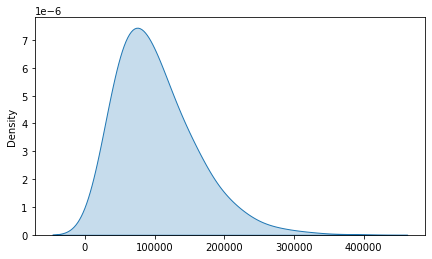

In [5]:
plt.rcParams["figure.figsize"] = (7,4)
seaborn.kdeplot(data, bw_adjust=2, fill="b")

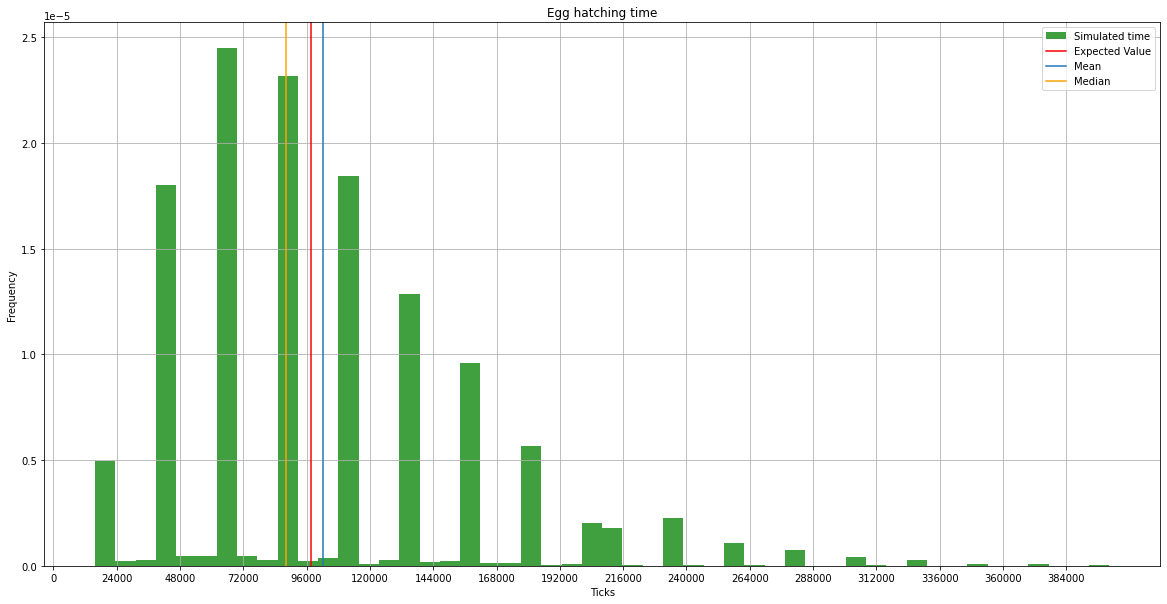

In [6]:
plt.rcParams["figure.figsize"] = (20,10)
n, bins, patches = plt.hist(data, 50, density=True, facecolor='g', alpha=0.75, label="Simulated time")
plt.xlabel("Ticks")
plt.ylabel("Frequency")
plt.title("Egg hatching time")
E = 3 * ticks_per_day * 1 / (ticks_per_day * 3/4096 * (0.96 * 1/500 + 0.04 * 1))
plt.axvline(x=E, c="r", label="Expected Value")
plt.axvline(x=statistics.mean(data), label="Mean")
plt.axvline(x=statistics.median(data), c="orange", label="Median")
ticks = range(0, math.floor(max(data)), ticks_per_day)
plt.xticks(ticks, ticks)
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,1,2]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
plt.show()

Note: the expected value is a little arbitrary here. It's the expected number of ticks it takes for an egg to hatch but it's quite dependent on the simulation start time (noon in this case). Shifting the simulation start time will shift the EV.

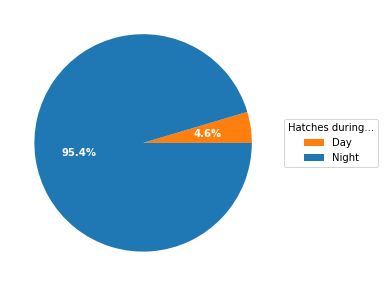

In [7]:
plt.rcParams["figure.figsize"] = (10,5)
night_hatches = sum(nights)
pie = [len(nights) - night_hatches, night_hatches]
wedges, texts, autotexts = plt.pie(pie, colors=["tab:orange", "tab:blue"], autopct=lambda v: "{:.1f}%".format(v), textprops=dict(color="w"))
plt.legend(wedges, ["Day", "Night"],
          title="Hatches during...",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight="bold")
None

### Looking at day number rather than tick number

In [8]:
ddata = [x // ticks_per_day for x in data]

<AxesSubplot:ylabel='Density'>

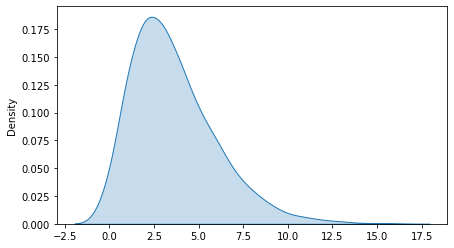

In [9]:
plt.rcParams["figure.figsize"] = (7,4)
seaborn.kdeplot(ddata, bw_adjust=1.5, fill="b")

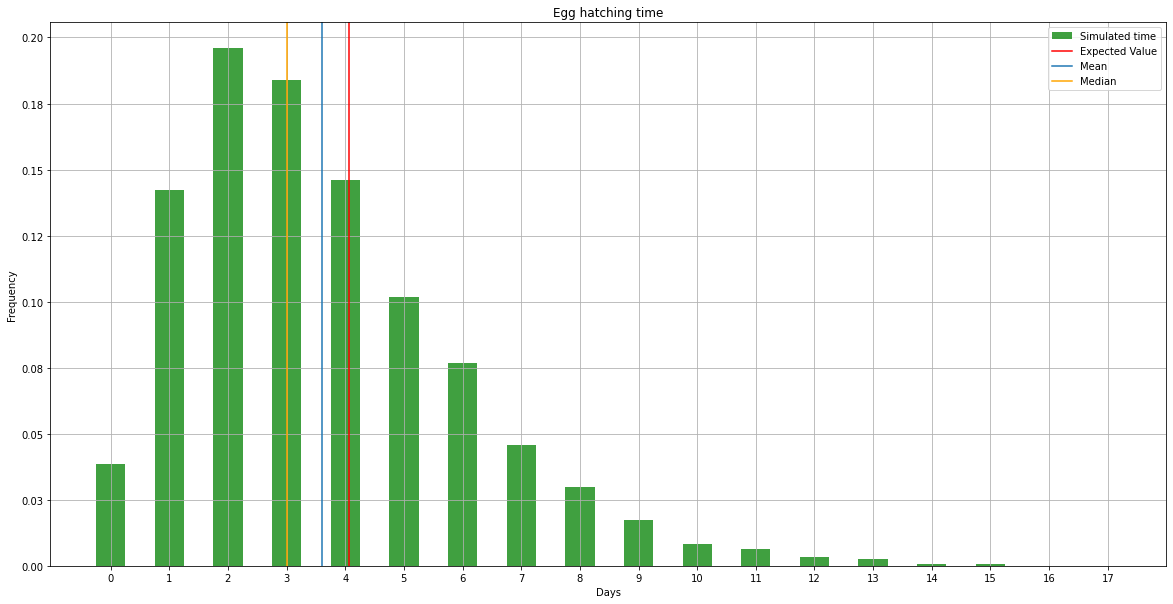

In [10]:
plt.rcParams["figure.figsize"] = (20,10)
xmax = 17
bins = np.arange(0, math.floor(max(ddata)), .5)
n, bins, patches = plt.hist(ddata, bins, density=True, facecolor="g", alpha=0.75, label="Simulated time")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.title("Egg hatching time")
E = 3 / (ticks_per_day * 3/4096 * (0.96 * 1/500 + 0.04 * 1))
plt.axvline(x=E + 0.25, c="r", label="Expected Value")
plt.axvline(x=statistics.mean(ddata) + 0.25, label="Mean")
plt.axvline(x=statistics.median(ddata) + 0.25, c="orange", label="Median")
ticks = np.arange(0.25, xmax + 1, 1)
labels = np.arange(0, xmax + 1, 1)
plt.xticks(ticks, labels)
plt.xlim((plt.xlim()[0], xmax + 1.25))
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,1,2]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
# bins are sliced in half for appearance but that double's their height, so re-lable the y-axis so the user sees the right thing
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda v, i: "{:0.2f}".format(v / 2))
plt.show()

### Binomial calculation
Calculating the chance of an egg hatching after $i$ days is a binomial problem. The binomial calculation is complicated because a certain window has a different probability of success. Working out the binomial calculation the hard way yields:
$$\text{binompdf}(n, \delta, p, \alpha, k) = \sum_{i=0}^{k}\left(\binom{n-\delta}{k-i}\binom{\delta}{i} p^{k-i} (1-p)^{n-\delta-k+i} \alpha^{i} (1-\alpha)^{\delta-i}\right)$$
Where $n$ is the number of trials, $\delta$ is the number of trials which get the special probability, $p$ is the default probability, $\alpha$ is special probability, and $k$ is the number of successes.
It appears to be valid to use a simple binomial calculation with a weighted average chance for all ticks if the day is treated discretely. This makes intuitive sense, however, I haven't proven the equivalence rigorously.
$$=\binom{n}{k}q^k(1-q)^{n-k}$$
Where $q$ is the weighted average probability in the window:
$$q = \frac{p(n-\delta)+\alpha\delta}{n}$$

In [11]:
def binompdf(n, p, k):
	return mp.binomial(n, k) * p**k * (1 - p)**(n - k)
def binomcdf(n, p, k):
	return sum([binompdf(n, p, x) for x in range(k + 1)])
av_chance_per_tick = 3/4096 * (0.96 * 1/500 + 0.04 * 1)
# I put too much work into figuring out this formula to just remove the method from the code :(
#def vbinompdf(n, delta, p, alpha, k):
#	s = 0
#	for i in range(k + 1):
#		s += mp.binomial(n - delta, k - i) * p**(k - i) * (1 - p)**(n - delta - k + i) \
#			* mp.binomial(delta, i) * alpha**(i) * (1 - alpha)**(delta - i)
#	return s
#def vbinomcdf(n, delta, p, alpha, k):
#	return sum([vbinompdf(n, delta, p, alpha, x) for x in range(k + 1)])
def prob_hatch_by_day(i):
	return 1 - binomcdf(i * ticks_per_day, av_chance_per_tick, 2)
	#return 1 - vbinomcdf(i * ticks_per_day, i * 0.04 * ticks_per_day, 3/4096 * 1/500, 3/4096, 2)

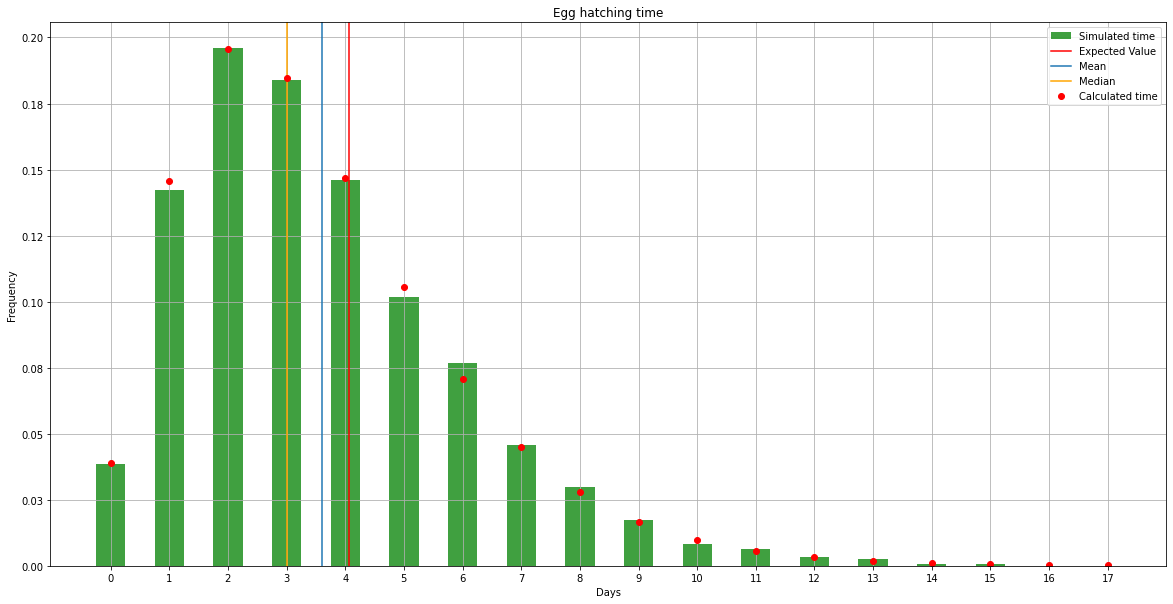

In [12]:
plt.rcParams["figure.figsize"] = (20,10)
xmax = 17
bins = np.arange(0, math.floor(max(ddata)), .5)
n, bins, patches = plt.hist(ddata, bins, density=True, facecolor='g', alpha=0.75, label="Simulated time")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.title("Egg hatching time")
E = 3 / (ticks_per_day * 3/4096 * (0.96 * 1/500 + 0.04 * 1))
plt.axvline(x=E + 0.25, c="r", label="Expected Value")
plt.axvline(x=statistics.mean(ddata) + 0.25, label="Mean")
plt.axvline(x=statistics.median(ddata) + 0.25, c="orange", label="Median")
ticks = np.arange(0.25, xmax + 1, 1)
labels = np.arange(0, xmax + 1, 1)
plt.xticks(ticks, labels)
plt.xlim((plt.xlim()[0], xmax + 1.25))
plt.grid(True)
plt.plot([x + 0.25 for x in range(xmax + 1)],
		 [(prob_hatch_by_day(x + 1) - prob_hatch_by_day(x)) * 2 for x in range(xmax + 1)],
		 "ro", label="Calculated time")
handles, labels = plt.gca().get_legend_handles_labels()
order = [4,0,1,2,3]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda v, i: "{:0.2f}".format(v / 2))
plt.show()

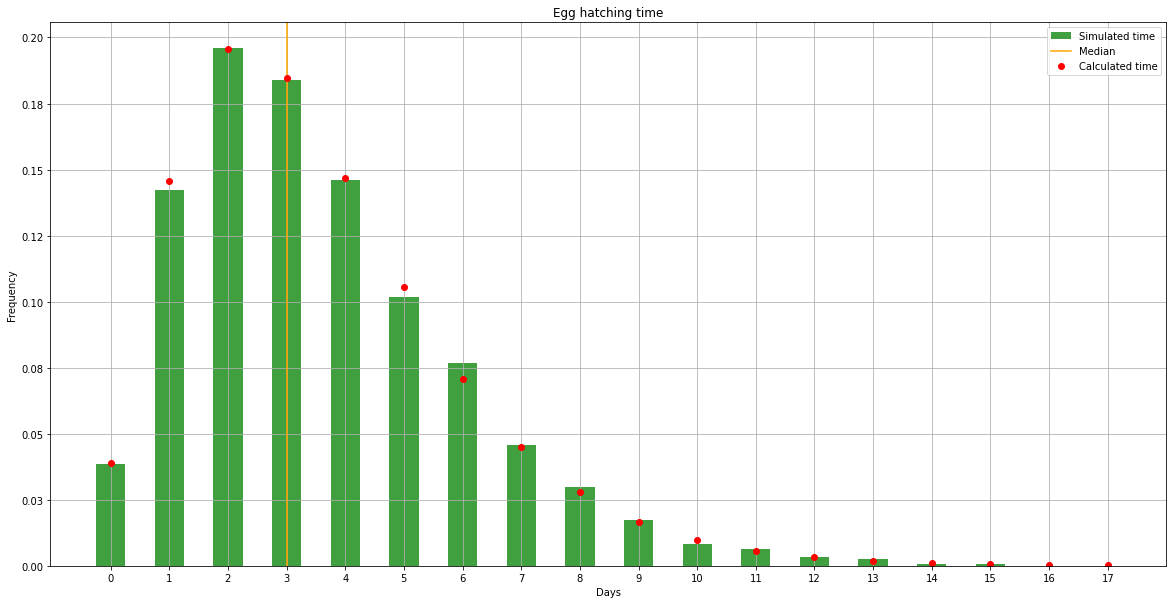

In [13]:
# plot used in the README with some of the info removed
plt.rcParams["figure.figsize"] = (20,10)
xmax = 17
bins = np.arange(0, math.floor(max(ddata)), .5)
n, bins, patches = plt.hist(ddata, bins, density=True, facecolor='g', alpha=0.75, label="Simulated time")
plt.xlabel("Days")
plt.ylabel("Frequency")
plt.title("Egg hatching time")
E = 3 / (ticks_per_day * 3/4096 * (0.96 * 1/500 + 0.04 * 1))
plt.axvline(x=statistics.median(ddata) + 0.25, c="orange", label="Median")
ticks = np.arange(0.25, xmax + 1, 1)
labels = np.arange(0, xmax + 1, 1)
plt.xticks(ticks, labels)
plt.xlim((plt.xlim()[0], xmax + 1.25))
plt.grid(True)
plt.plot([x + 0.25 for x in range(xmax + 1)],
		 [(prob_hatch_by_day(x + 1) - prob_hatch_by_day(x)) * 2 for x in range(xmax + 1)],
		 "ro", label="Calculated time")
handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,1]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
ax = plt.gca()
ax.yaxis.set_major_formatter(lambda v, i: "{:0.2f}".format(v / 2))
plt.show()

### Chance of hatching after...

In [14]:
table = []
for i in range(1, 19):
	table.append([i - 1, 1 - binomcdf(i * ticks_per_day, av_chance_per_tick, 2)])
print(tabulate.tabulate(table, headers=["Day", "Cumulative Probability"], floatfmt=".2f"))

  Day    Cumulative Probability
-----  ------------------------
    0                      0.04
    1                      0.18
    2                      0.38
    3                      0.56
    4                      0.71
    5                      0.82
    6                      0.89
    7                      0.93
    8                      0.96
    9                      0.98
   10                      0.99
   11                      0.99
   12                      1.00
   13                      1.00
   14                      1.00
   15                      1.00
   16                      1.00
   17                      1.00
